## Table of Content:
1. Importing Libraries and Data
2. Data Preprocessing and Feature Engineering
3. Model Building and Evaluation

## 1. Importing Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# import multinomial naive bayes
from sklearn.naive_bayes import MultinomialNB, GaussianNB


from sklearn.metrics import confusion_matrix, classification_report


In [3]:
data=pd.read_csv('Resources/prepared_dataset.csv')
data.fillna(' ',inplace=True)
data.head()

,Body,Label,word_count,char_count,sentence_count
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1,168,1111,11
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,76,753,25
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,63,610,21
3,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1,63,610,21
4,##############################################...,1,398,2863,66


## 2. Data Preprocessing and Feature Engineering

In [4]:

# maximum no of words:\
max_features=30000


# TF-IDF
tfidf=TfidfVectorizer(max_features=max_features)

# Split the data into training and testing sets

X=data['Body']
y=data['Label']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

X_train=tfidf.fit_transform(X_train)
X_test=tfidf.transform(X_test)



In [5]:
X_train.shape

(14875, 30000)

## 3. Model Building and Evaluation

In [6]:

# Multinomial Naive Bayes
clf=MultinomialNB()
clf.fit(X_train,y_train)

y_pred = (clf.predict_proba(X_test)[:,1] >= 0.25).astype(bool) # set threshold as 0.25

print(confusion_matrix(y_test,y_pred))

[[2145   98]
 [  14 1462]]


In [7]:

clf2=GaussianNB()

clf2.fit(X_train.toarray(),y_train)

y_pred2 = (clf2.predict_proba(X_test.toarray())[:,1] >= 0.25).astype(bool) # set threshold as 0.25

print(confusion_matrix(y_test,y_pred2))


[[2121  122]
 [ 140 1336]]


In [8]:

report=classification_report(y_test,y_pred)
matrix=confusion_matrix(y_test,y_pred)
print('Classification Report : \n',classification_report(y_test,y_pred))


Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.96      0.97      2243
           1       0.94      0.99      0.96      1476

    accuracy                           0.97      3719
   macro avg       0.97      0.97      0.97      3719
weighted avg       0.97      0.97      0.97      3719



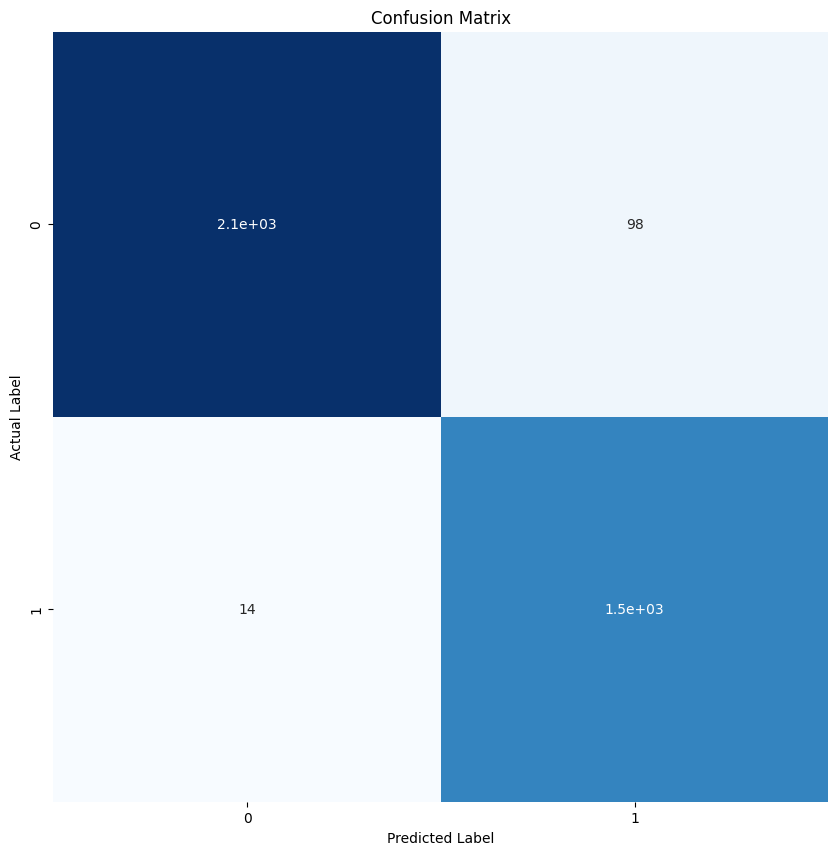

In [9]:
plt.figure(figsize=(10,10))
plt.title('Confusion Matrix')
sns.heatmap(matrix,annot=True,cmap='Blues',cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.savefig('Captures/confusion_matrix_NB.png',dpi=400,bbox_inches='tight')

## Hyperparameter Tuning

In [10]:
# hyperparameter tuning

from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search

param_grid = {
    'alpha': [0.1,0.5,1,2,5,10,20,50,100],
    'fit_prior': [True,False]
}


# Create a based model

nb = MultinomialNB()

# Instantiate the grid search model

grid_search = GridSearchCV(estimator = nb, param_grid = param_grid,

                            cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train,y_train)

print(grid_search.best_params_)

print(grid_search.best_score_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.1s
[CV] END ..........................alpha=0.5, fit_prior=True; total time=   0.1s
[CV] END .........................alpha=0.5, fit_prior=False; total time=   0.1s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.1s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.1s
[CV] END ..........................alpha=0.5, fit_prior=True; total time=   0.1s
[CV] END .........................alpha=0.5, fit_prior=False; total time=   0.1s
[CV] END .........................alpha=0.1, fit_prior=False; total time=   0.1s
[CV] END .........................alpha=0.5, fit_prior=False; total time=   0.1s
[CV] END ..........................alpha=0.1, fit_prior=True; total time=   0.1s
[CV] END ............................alpha=1, fit_prior=True; total time=   0.1s
[CV] END ............................alpha=1, fi

In [11]:
import joblib

# Saving the Model with best parameters
joblib.dump(grid_search.best_estimator_,'Resources/Naive_Bayes.pkl')

# saving the tfidf vectorizer using joblib
joblib.dump(tfidf,'Resources/vectorizer.pkl')


['Resources/vectorizer.pkl']

## Reuse

In [12]:
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords

import re

#stopwords of english language
stops=set(stopwords.words('english'))

lemmatizer=WordNetLemmatizer()

def clean_text(text):
    # replacing all characters except alphabets with space
    temp=re.sub('[^a-zA-Z]',' ',text)

    # Lowering all the characters
    temp=temp.lower()

    # Splitting the sentences into set of words
    temp=temp.split()

    temp=[x for x in temp if x not in stops]
    

    # lemmatize the word if it is not present in stopwords
    temp=[lemmatizer.lemmatize(word) for word in temp ]

    #Joining the Lemmatized words with space
    temp=' '.join(temp)

    # Returning the cleaned sentences
    return temp


In [13]:

vectorizer=joblib.load('Resources/vectorizer.pkl')

clf=joblib.load('Resources/Naive_Bayes.pkl')



def predict_text(text):

    if len(text)<=50:

        return "Please enter more words to get a prediction"

    # apply clean text function

    text=clean_text(text)

    text=[text]

    
    
    
    text=vectorizer.transform(text)
    prediction=clf.predict_proba(text)
    return prediction[0][1]>=0.2


# Note: the model is trained on the data which is  cleaned and preprocessed. So, the input text should be in the same format as the data.
#          You may use the clean_text function to clean the text before passing it to the model. (in the data_preprocessing notebook)
# The text to be predicted should be adequete enough to be classified as either 'Ask HN' or 'Show HN'
# The small text like 'Hi' or 'Hello' will not be classified properly.

# Important Mail
sample_email1="Subject Women in Tech | Google Developer Student Clubs KIIT Body: Hey folks! GDSC KIIT is back with another event and this time we're hosting Women in Tech. Join us for a fun-filled networking session where you get to learn from your peers and seniors to become the best female developer you can be! Date: 29th October Time: 2pm-6pm Venue: To be notified soon"

# Spam Mail
sample_email2="Subject: futuresignals this message is being sent to you in compliance with the proposed federal legislation for commercial email ( s . 1618 - section 301 ) . http : / / www . senate . gov / ~ murkowski / commercialemail / emailamendtext . html "" pursuant to section 301 , paragraph ( a ) ( 2 ) ( c ) of s . 1618 , further transmissions to you by the sender of this email may be stopped at no cost to you by sending a reply to this email by following the directions below this message . = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = attention futures traders receive real - time instant futuresignals over the internet by noted cta . futures traders , our service sends instant futuresignals via the internet as they are generated for the following markets : s&p 500 , nasdaq 100 , e - mini , unique futures trading opportunities . our futuresignals come with profit objectives for scalpers , daytraders and postion traders . we also issue trailing stops and important info we hear in the pits throughout the day . our service has been featured in futures magazine . for a free 3 day trial go to : http : / / www . bulkmate . com / futuresignals / http : / / www . bulkmate . com / futuresignals / futures trading involves risk . only use risk capital . please read cftc disclaimer on our website . to be removed from this list , simply send a blank email to : fsremove @ do-it - now . net note : it is not our intention to infiltrate or advertise to any investing / trading-related discussion groups . if this has been the case , our apologies and please follow the removal instructions above . sent from : futuresignals email : fs @ do-it - now . net address : po box 351 , verplanck , ny , 10596 telephone : 212-501 - 4281 "

print(predict_text(sample_email1),predict_text(sample_email2))

False True
